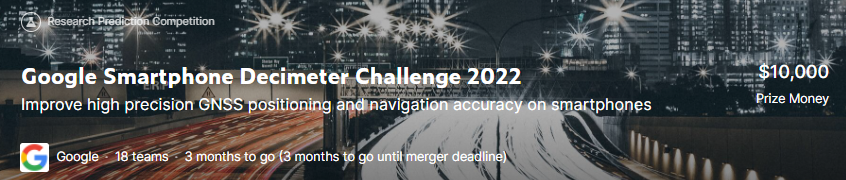

## It seems that the difficulty level is higher than the previous competition.
前回のコンペよりも難易度があがっているようです。

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
!pip install folium
!pip install simdkalman
import os
import pickle
import sys
import warnings
from glob import glob
import requests
import folium
from shapely.geometry import Point, shape
import shapely.wkt
from geopandas import GeoDataFrame
import simdkalman
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm
pd.options.mode.use_inf_as_na = True

In [ ]:
cname_ = glob('../input/smartphone-decimeter-2022/train/*')
tmp = []
for i in cname_:
    tmp.extend(glob(f'{i}/*'))

cname=[]

for r in tmp:
    cname.append([r.split('/')[4],r.split('/')[5]])
    
cname = pd.DataFrame(sorted(cname))
cname

### List of mobile phones used in train

trainで使っている携帯電話の一覧

In [ ]:
cname[1].value_counts()

### List of mobile phones used in test

testで使っている携帯電話の一覧

In [ ]:
cname_ = glob('../input/smartphone-decimeter-2022/test/*')
tmp = []
for i in cname_:
    tmp.extend(glob(f'{i}/*'))

cname=[]

for r in tmp:
    cname.append([r.split('/')[4],r.split('/')[5]])
    
cname = pd.DataFrame(sorted(cname))
cname[1].value_counts()

### Since the train is 2020 and the test is 2021-2022, it seems that the mobile phone used is a little different.

trainが2020年、testが2021-2022年なので使っている携帯電話が少し違うようです。

### 💼 Read the metadata file
💼metadataのファイルを読んでみる

In [ ]:
import json
raw = open('../input/smartphone-decimeter-2022/metadata/raw_state_bit_map.json', 'r')
json.load(raw)

In [ ]:
import json
bit = open('../input/smartphone-decimeter-2022/metadata/accumulated_delta_range_state_bit_map.json', 'r')
json.load(bit)

In [ ]:
mapping = pd.read_csv('../input/smartphone-decimeter-2022/metadata/constellation_type_mapping.csv')
mapping

### 💼 Read the sample file(2020-05-15-US-MTV-1)
💼sample(2020-05-15-US-MTV-1)のファイルを読んでみる

In [ ]:
ground = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/ground_truth.csv')
ground

<pre>
MessageType - "Fix", the prefix of sentence.

Provider - "GT", short for ground truth.

[Latitude/Longitude]Degrees - The WGS84 latitude, longitude (in decimal degrees) estimated by the reference GNSS receiver (NovAtel SPAN). When extracting from the NMEA file, linear interpolation has been applied to align the location to the expected non-integer timestamps.

AltitudeMeters - The height above the WGS84 ellipsoid (in meters) estimated by the reference GNSS receiver.

SpeedMps* - The speed over ground in meters per second.

AccuracyMeters - The estimated horizontal accuracy radius in meters of this location at the 68th percentile confidence level. This means that there is a 68% chance that the true location of the device is within a distance of this uncertainty of the reported location.

BearingDegrees - Bearing is measured in degrees clockwise from north. It ranges from 0 to 359.999 degrees.

UnixTimeMillis - An integer number of milliseconds since the GPS epoch (1970/1/1 midnight UTC). Converted from GnssClock.

In [ ]:
imu= pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/device_imu.csv')
imu

<pre>
MessageType - which of the three instruments the row's data is from.

utcTimeMillis - The sum of elapsedRealtimeNanos below and the estimated device boot time at UTC, after a recent NTP (Network Time Protocol) sync.

Measurement[X/Y/Z] - [x/y/z]_uncalib without bias compensation.

Bias[X/Y/Z]MicroT - Estimated [x/y/z]_bias. Null in datasets collected in earlier dates.

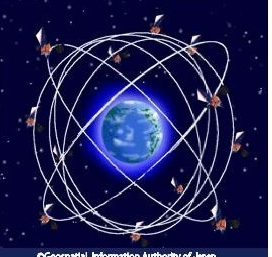

## How can we obtain highly accurate location information?

### Highly accurate positioning information is necessary to realize automated driving, but currently satellite positioning alone is not accurate enough.
### Therefore, positioning with an inertial measurement unit (IMU) can provide centimeter-class positioning, bringing us closer to the realization of automated driving.

高精度な位置情報を取得するにはどうしたら良いの？

自動運転を実現する為には高精度な測位情報が必要ですが、現状人工衛星の測位だけでは精度が足りません。
そこで慣性測定装置（IMU：Inertial Measurement Unit）との組み合わせで測位することでcm級の測位ができ、自動運転の実現が近づいてきました。

### GNSS (Global Navigation Satellite System) is a general term for satellite positioning systems such as GPS, Quasi-Zenith Satellite (QZSS), GLONASS, and Galileo. GNSS surveying is a highly accurate surveying method that uses radio waves transmitted from GNSS satellites that orbit the earth to obtain coordinates. Since the receiver installed at the station only receives radio waves from the sky, it is possible to secure visibility between stations and perform surveys regardless of the weather.

### GNSS surveying is currently the mainstream of geodetic surveying because it enables three-dimensional high-precision surveying and can reduce and improve the efficiency of surveying work.

### Coordinate values ​​obtained by GNSS such as car navigation systems and smartphones are generally expressed in the WGS 84 coordinate system. Both the WGS 84 coordinate system and the ITRF coordinate system are earth-centered coordinate systems. WGS 84 has been revised several times so far, but there is no problem in approaching the ITRF system each time and treating it as almost the same now, and there is no practical difference. However, surveying in Japan requires the use of the ITRF coordinate system GRS80 ellipsoid.

GNSS（Global Navigation Satellite System / 全球測位衛星システム）は、GPS、準天頂衛星（QZSS）、GLONASS、Galileo等の衛星測位システムの総称です。GNSS測量は、地球上空を周回するGNSS衛星から送られる電波を利用して、座標を求める高精度な測量方法です。測点に据え付けた受信機で上空からの電波を受信するだけなので、これまでのような測点間の視通の確保や天候の良し悪しに無関係に測量が実施できます。

　GNSS測量は、3次元の高精度測量が可能であり、測量作業も軽減化・効率化が図れるため、現在、測地測量の主流になっています。

　カーナビやスマートフォンなどのGNSSにより得られる座標値は、一般的にWGS 84座標系で表されています。 WGS 84座標系とITRF座標系はともに地球中心の座標系です。WGS 84はこれまでに数回の改定を行っていますが、その都度ITRF系に接近し現在はほとんど同一のものとして扱っても問題なく、実用上の違いはありません。ただし、日本国内の測量ではITRF座標系GRS80楕円体を用いるよう定められています。

In [ ]:
gnss = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/device_gnss.csv')
gnss

<pre>
MessageType - "Raw", the prefix of sentence.

utcTimeMillis - Milliseconds since UTC epoch (1970/1/1), converted from GnssClock.

TimeNanos - The GNSS receiver internal hardware clock value in nanoseconds.

LeapSecond - The leap second associated with the clock's time.

FullBiasNanos - The difference between hardware clock (getTimeNanos()) inside GPS receiver and the true GPS time since 0000Z, January 6, 1980, in nanoseconds.

BiasNanos - The clock's sub-nanosecond bias.

BiasUncertaintyNanos - The clock's bias uncertainty (1-sigma) in nanoseconds.

DriftNanosPerSecond - The clock's drift in nanoseconds per second.

DriftUncertaintyNanosPerSecond - The clock's drift uncertainty (1-sigma) in nanoseconds per second.

HardwareClockDiscontinuityCount - Count of hardware clock discontinuities.

Svid - The satellite ID.

TimeOffsetNanos - The time offset at which the measurement was taken in nanoseconds.

State - Integer signifying sync state of the satellite. Each bit in the integer attributes to a particular state information of the measurement. See the metadata/raw_state_bit_map.json file for the mapping between bits and states.

ReceivedSvTimeNanos - The received GNSS satellite time, at the measurement time, in nanoseconds.

ReceivedSvTimeUncertaintyNanos - The error estimate (1-sigma) for the received GNSS time, in nanoseconds.

Cn0DbHz - The carrier-to-noise density in dB-Hz.

PseudorangeRateMetersPerSecond - The pseudorange rate at the timestamp in m/s.

PseudorangeRateUncertaintyMetersPerSecond - The pseudorange's rate uncertainty (1-sigma) in m/s.

AccumulatedDeltaRangeState - This indicates the state of the 'Accumulated Delta Range' measurement. Each bit in the integer attributes to state of the measurement. See the metadata/accumulated_delta_range_state_bit_map.json file for the mapping between bits and states.

AccumulatedDeltaRangeMeters - The accumulated delta range since the last channel reset, in meters.

AccumulatedDeltaRangeUncertaintyMeters - The accumulated delta range's uncertainty (1-sigma) in meters.

CarrierFrequencyHz - The carrier frequency of the tracked signal.

MultipathIndicator - A value indicating the 'multipath' state of the event.

ConstellationType - GNSS constellation type. The mapping to human readable values is provided in the metadata/constellation_type_mapping.csv file.

CodeType - The GNSS measurement's code type. Only available in recent logs.

ChipsetElapsedRealtimeNanos - The elapsed real-time of this clock since system boot, in nanoseconds. Only available in recent logs.

ArrivalTimeNanosSinceGpsEpoch - An integer number of nanoseconds since the GPS epoch (1980/1/6 midnight UTC). Its value equals round((Raw::TimeNanos - Raw::FullBiasNanos), for each unique epoch described in the Raw sentences.

RawPseudorangeMeters - Raw pseudorange in meters. It is the product between the speed of light and the time difference from the signal transmission time (receivedSvTimeInGpsNanos) to the signal arrival time (Raw::TimeNanos - Raw::FullBiasNanos - Raw;;BiasNanos). Its uncertainty can be approximated by the product between the speed of light and the ReceivedSvTimeUncertaintyNanos.

SignalType - The GNSS signal type is a combination of the constellation name and the frequency band. Common signal types measured by smartphones include GPS_L1, GPS_L5, GAL_E1, GAL_E5A, GLO_G1, BDS_B1I, BDS_B1C, BDS_B2A, QZS_J1, and QZS_J5.

ReceivedSvTimeNanosSinceGpsEpoch - The signal transmission time received by the chipset, in the numbers of nanoseconds since the GPS epoch. Converted from ReceivedSvTimeNanos, this derived value is in a unified time scale for all constellations, while ReceivedSvTimeNanos refers to the time of day for GLONASS and the time of week for non-GLONASS constellations.

SvPosition[X/Y/Z]EcefMeters - The satellite position (meters) in an ECEF coordinate frame at best estimate of “true signal transmission time” defined as ttx = receivedSvTimeInGpsNanos - satClkBiasNanos (defined below). They are computed with the satellite broadcast ephemeris, and have ~1-meter error with respect to the true satellite position.

Sv[Elevation/Azimuth]Degrees - The elevation and azimuth in degrees of the satellite. They are computed using the WLS estimated user position.

SvVelocity[X/Y/Z]EcefMetersPerSecond - The satellite velocity (meters per second) in an ECEF coordinate frame at best estimate of “true signal transmission time” ttx. They are computed with the satellite broadcast ephemeris, with this algorithm.

SvClockBiasMeters - The satellite time correction combined with the satellite hardware delay in meters at the signal transmission time (receivedSvTimeInGpsNanos). Its time equivalent is termed as satClkBiasNanos. satClkBiasNanos equals the satelliteTimeCorrection minus the satelliteHardwareDelay. As defined in IS-GPS-200H Section 20.3.3.3.3.1, satelliteTimeCorrection is calculated from ∆tsv = af0 + af1(t - toc) + af2(t - toc)2 + ∆tr, while satelliteHardwareDelay is defined in Section 20.3.3.3.3.2. Parameters in the equations above are provided on the satellite broadcast ephemeris.

SvClockDriftMetersPerSecond - The satellite clock drift in meters per second at the signal transmission time (receivedSvTimeInGpsNanos). It equals the difference of the satellite clock biases at t+0.5s and t-0.5s.

IsrbMeters - The Inter-Signal Range Bias (ISRB) in meters from a non-GPS-L1 signal to GPS-L1 signals. For example, when the isrbM of GPS L5 is 1000m, it implies that a GPS L5 pseudorange is 1000m longer than the GPS L1 pseudorange transmitted by the same GPS satellite. It's zero for GPS-L1 signals. ISRB is introduced in the GPS chipset level and estimated as a state in the Weighted Least Squares engine.

IonosphericDelayMeters - The ionospheric delay in meters, estimated with the Klobuchar model.

TroposphericDelayMeters - The tropospheric delay in meters, estimated with the EGNOS model by Nigel Penna, Alan Dodson and W. Chen (2001).

WlsPositionXEcefMeters - WlsPositionYEcefMeters,WlsPositionZEcefMeters: User positions in ECEF estimated by a Weighted-Least-Square (WLS) solver.



## Let's map the Ground True data on the map.

Ground Trueのデータを地図上にマップしてみます。

In [ ]:
from folium import plugins
df_locs = list(ground[['LatitudeDegrees','LongitudeDegrees']].values)
fol_map = folium.Map([ground['LatitudeDegrees'].median(), ground['LongitudeDegrees'].median()],zoom_start=11)
heat_map = plugins.HeatMap(df_locs)
fol_map.add_child(heat_map)
markers = plugins.MarkerCluster(locations = df_locs)
fol_map.add_child(markers)


### In this competition, this driving data is corrected using data from mobile phones, etc., and the correct driving route is presented.

このコンペは、この走行データを携帯電話などのデータを利用して補正して、正しい走行ルートを提示するものです。

## 💼 Read thesupplemental
💼supplementalのファイルを読んでみる

### gnss_log.txt

In [ ]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_log.txt', 'r')
log = f.read()
f.close()
log[:500]

### Txt to Pandas

In [ ]:
    path ='../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_log.txt'
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
      if dataline !='' and dataline[0] !='':
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            if dataline !='' and dataline[0] !='':
                datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

In [ ]:
results['Raw']

<pre>
utcTimeMillis - Milliseconds since UTC epoch (1970/1/1), converted from GnssClock

TimeNanos - The GNSS receiver internal hardware clock value in nanoseconds.

LeapSecond - The leap second associated with the clock's time.

TimeUncertaintyNanos - The clock's time uncertainty (1-sigma) in nanoseconds.

FullBiasNanos - The difference between hardware clock getTimeNanos() inside GPS receiver and the true GPS time since 0000Z, January 6, 1980, in nanoseconds.

BiasNanos - The clock's sub-nanosecond bias.

BiasUncertaintyNanos - The clock's bias uncertainty (1-sigma) in nanoseconds.

DriftNanosPerSecond - The clock's drift in nanoseconds per second.

DriftUncertaintyNanosPerSecond - The clock's drift uncertainty (1-sigma) in nanoseconds per second.

HardwareClockDiscontinuityCount - Count of hardware clock discontinuities.

Svid - The satellite ID. More info can be found here.

TimeOffsetNanos - The time offset at which the measurement was taken in nanoseconds.

State - Integer signifying sync state of the satellite. Each bit in the integer attributes to a particular state information of the measurement. See the metadata/raw_state_bit_map.json file for the mapping between bits and states.

ReceivedSvTimeNanos - The received GNSS satellite time, at the measurement time, in nanoseconds.

ReceivedSvTimeUncertaintyNanos - The error estimate (1-sigma) for the received GNSS time, in nanoseconds.

Cn0DbHz - The carrier-to-noise density in dB-Hz.

PseudorangeRateMetersPerSecond - The pseudorange rate at the timestamp in m/s.

PseudorangeRateUncertaintyMetersPerSecond - The pseudorange's rate uncertainty (1-sigma) in m/s.

AccumulatedDeltaRangeState - This indicates the state of the 'Accumulated Delta Range' measurement. Each bit in the integer attributes to state of the measurement. See the metadata/accumulated_delta_range_state_bit_map.json file for the mapping between bits and states.

AccumulatedDeltaRangeMeters - The accumulated delta range since the last channel reset, in meters.

AccumulatedDeltaRangeUncertaintyMeters - The accumulated delta range's uncertainty (1-sigma) in meters.

CarrierFrequencyHz - The carrier frequency of the tracked signal.

CarrierCycles - The number of full carrier cycles between the satellite and the receiver. Null in these datasets.

CarrierPhase - The RF phase detected by the receiver. Null in these datasets.

CarrierPhaseUncertainty - The carrier-phase's uncertainty (1-sigma). Null in these datasets.

MultipathIndicator - A value indicating the 'multipath' state of the event.

SnrInDb - The (post-correlation & integration) Signal-to-Noise ratio (SNR) in dB.

ConstellationType - GNSS constellation type. It's an integer number, whose mapping to string value is provided in the constellation_type_mapping.csv file.

AgcDb - The Automatic Gain Control level in dB.

BasebandCn0DbHz - The baseband carrier-to-noise density in dB-Hz. Only available in Android 11.

FullInterSignalBiasNanos - The GNSS measurement's inter-signal bias in nanoseconds with sub-nanosecond accuracy. Only available in Pixel 5 logs in 2021. Only available in Android 11.

FullInterSignalBiasUncertaintyNanos - The GNSS measurement's inter-signal bias uncertainty (1 sigma) in nanoseconds with sub-nanosecond accuracy. Only available in Android 11.

SatelliteInterSignalBiasNanos - The GNSS measurement's satellite inter-signal bias in nanoseconds with sub-nanosecond accuracy. Only available in Android 11.

SatelliteInterSignalBiasUncertaintyNanos - The GNSS measurement's satellite inter-signal bias uncertainty (1 sigma) in nanoseconds with sub-nanosecond accuracy. Only available in Android 11.

CodeType - The GNSS measurement's code type. Only available in recent logs.

ChipsetElapsedRealtimeNanos - The elapsed real-time of this clock since system boot, in nanoseconds. Only available in recent logs.



In [ ]:
results['UncalAccel']

In [ ]:
results['UncalGyro']

In [ ]:
results[ 'UncalMag']

In [ ]:
results['Fix']

In [ ]:
results['Status']

<pre>

UnixTimeMillis - Milliseconds since UTC epoch (1970/1/1), reported from the last location changed by GPS provider.

SignalCount - The total number of satellites in the satellite list.

SignalIndex - The index of current signal.

ConstellationType: The constellation type of the satellite at the specified index.

Svid: The satellite ID.

CarrierFrequencyHz: The carrier frequency of the signal tracked.

Cn0DbHz: The carrier-to-noise density at the antenna of the satellite at the specified index in dB-Hz.

AzimuthDegrees: The azimuth the satellite at the specified index.

ElevationDegrees: The elevation of the satellite at the specified index.

UsedInFix: Whether the satellite at the specified index was used in the calculation of the most recent position fix.

HasAlmanacData: Whether the satellite at the specified index has almanac data.

HasEphemerisData: Whether the satellite at the specified index has ephemeris data.

BasebandCn0DbHz: The baseband carrier-to-noise density of the satellite at the specified index in dB-Hz.

In [ ]:
results['OrientationDeg']

<pre>
utcTimeMillis - The sum of elapsedRealtimeNanos below and the estimated device boot time at UTC, after a recent NTP (Network Time Protocol) sync.

elapsedRealtimeNanos - The time in nanoseconds at which the event happened.

yawDeg - If the screen is in portrait mode, this value equals the Azimuth degree (modulus to 0°~360°). If the screen is in landscape mode, it equals the sum (modulus to 0°~360°) of the screen rotation angle (either 90° or 270°) and the Azimuth degree. Azimuth, refers to the angle of rotation about the -z axis. This value represents the angle between the device's y axis and the magnetic north pole.

rollDeg - Roll, angle of rotation about the y axis. This value represents the angle between a plane perpendicular to the device's screen and a plane perpendicular to the ground.

pitchDeg - Pitch, angle of rotation about the x axis. This value represents the angle between a plane parallel to the device's screen and a plane parallel to the ground.

### gnss_rinex.20o

In [ ]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_rinex.20o', 'r')
rinex = f.read()
f.close()
rinex[:500]

In [ ]:
rinex =pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_rinex.20o')
rinex

### span_log.nmea

In [ ]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/span_log.nmea', 'r')
span = f.read()
f.close()
span[:500]

In [ ]:
span = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/span_log.nmea')
span

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Submittion</span>

## This is a presentation. You need to enter and present the correct coordinates.

これが提示物。正しい座標を入れて提示する必要があります。

In [ ]:
sub = pd.read_csv('../input/smartphone-decimeter-2022/sample_submission.csv')
sub

In [ ]:
pd.read_csv('../input/smartphone-decimeter-2022/train/2020-08-06-US-MTV-2/GooglePixel4/ground_truth.csv')

In [ ]:
#Download geojson file of US San Francisco Bay Area.
r = requests.get("https://data.sfgov.org/api/views/wamw-vt4s/rows.json?accessType=DOWNLOAD")
r.raise_for_status()

#get geojson from response
data = r.json()

#get polygons that represents San Francisco Bay Area.
shapes = []
for d in data["data"]:
    shapes.append(shapely.wkt.loads(d[8]))
    
#Convert list of porygons to geopandas dataframe.
gdf_bayarea = pd.DataFrame()

#I'll use only 6 and 7th object.
for shp in shapes[5:7]:
    tmp = pd.DataFrame(shp, columns=["geometry"])
    gdf_bayarea = pd.concat([gdf_bayarea, tmp])
gdf_bayarea = GeoDataFrame(gdf_bayarea)

In [ ]:
gdf_bayarea

In [ ]:
%%capture
collectionNames = [item.split("/")[-1] for item in glob("../input/smartphone-decimeter-2022/train/*")]

gdfs = []
for collectionName in collectionNames:
    gdfs_each_collectionName = []
    csv_paths = glob(f"../input/smartphone-decimeter-2022/train/{collectionName}/*/ground_truth.csv")
    for csv_path in csv_paths:
        df_gt = pd.read_csv(csv_path)
        df_gt["geometry"] = [Point(lngDeg, latDeg) for lngDeg, latDeg in zip(df_gt["LatitudeDegrees"], df_gt["LongitudeDegrees"])]
        gdfs_each_collectionName.append(GeoDataFrame(df_gt))
    gdfs.append(gdfs_each_collectionName)
    
colors = ['blue', 'green', 'purple', 'orange']

In [ ]:
gdfs_each_collectionName

In [ ]:
for collectionName, gdfs_each_collectionName in zip(collectionNames, gdfs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    gdf_bayarea.plot(figsize=(10,10), color='none', edgecolor='gray', zorder=5, ax=axs[0])
    for i, gdf in enumerate(gdfs_each_collectionName):
        g2 = gdf.plot(color=colors[i], ax=axs[1])
        g2.set_title(f"Phone track of {collectionName}")

### EDA END

---------------------

## Kalman filter

### The Kalman filter is a method of estimating the state of the system from past (1 hour ago) estimates, current input to the system, and values measured from the system. However, it is assumed that the input is noisy and the measured value is also noisy. For example, noise is always mixed in the signal collected by the sensor. The Kalman filter is an algorithm constructed based on the idea of taking into account the influence of such actual phenomena, and it is possible to systematically optimize the design by estimating the state in a probabilistic framework. First of all, in constructing the Kalman filter, it is necessary to calculate the mathematical model to be controlled in order to calculate the estimated value from the input.

カルマンフィルター

カルマンフィルターとは、過去(1時刻前)の推定値と現在のシステムへの入力およびシステムから計測した値からシステムの状態を推定する方法になります。ただし、入力には雑音が乗っており、計測した値にも雑音が乗っているものとします。例えばセンサーで採取した信号には、必ず雑音が混入されます。カルマンフィルターはこのような実現象の影響を加味した考え方で構築されるアルゴリズムで、確率的な枠組みで状態推定を行うことでシステマティックに最適設計をすることができます。まず初めに、カルマンフィルターを構築するにあたり、入力から推定値を算出するために、制御対象となる数学モデルを算出する必要があります

In [ ]:
T = 1.0 
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[phone_col].unique()
    for phone in tqdm(unique_paths):
        data = df.loc[df[phone_col] == phone][[lat_col, lon_col]].values
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[df[phone_col] == phone, lat_col] = smoothed.states.mean[0, :, 0]
        df.loc[df[phone_col] == phone, lon_col] = smoothed.states.mean[0, :, 1]
    return df